In [36]:
from pathlib import Path
import pandas as pd

p = Path("/work/data/processed")  # コンテナ内の正しいパス
print(p.exists())                 # Trueになるはず
print(list(p.glob("*"))[:3])      # 最初の3つだけ確認

files = list(p.glob("*.parquet"))  # *.parquet または *.snappy.parquet に注意
print(len(files))

True
[PosixPath('/work/data/processed/part-00000-f07624b2-401d-4bc3-ade0-a8ae982c58b5-c000.snappy.parquet'), PosixPath('/work/data/processed/part-00000-7bf08c82-b8bf-4a93-a28f-4789185354c4-c000.snappy.parquet'), PosixPath('/work/data/processed/part-00001-5d0b89f1-3d52-4ae2-b5da-dd18305c5173-c000.snappy.parquet')]
4


# EDAでデータ概要を把握する

In [37]:
channel_df = pd.read_parquet(files[0])
print(channel_df.shape)
channel_df.head()


(1, 6)


,channel_id,channel_name,published_at,subscriber_count,total_views,video_count
0,UCCPkJMeZHhxKck-EptqQbBA,スキマスイッチ / SUKIMASWITCH,2019-04-04 07:11:52,437000,631905587,647


## channel_dfはチャンネルのメタデータ
- チャンネル名：スキマスイッチ
- 開設日や登録者数、総再生回数及び動画本数を確認

In [38]:
video_df = pd.read_parquet(files[1])
print(video_df.shape)
video_df.head()


(686, 9)


,video_id,title,published_at,view_count,like_count,comment_count,duration,tags,total_seconds
0,--CI9Gndvwc,スキマスイッチ「SUKIMASWITCH 20th Anniversary BEST 『PO...,2023-05-12 03:00:00,17404,493,27,PT2M27S,,147
1,-0TkcSGovqI,#奥田民生 × #スキマスイッチ と #ヴィンテージ #ギター の世界へ！,2022-03-23 03:09:43,6874,269,1,PT47S,,47
2,-29NR48c_Dk,#本日の全力少年＠大分県・別府ビーコンプラザ,2025-02-20 15:51:55,3477,198,5,PT1M10S,,70
3,-7_No7g0oa4,【公式】#86 好評企画！第3回『大橋CASINO』 開催！ピンチをチャンスへ！ スキマスイ...,2022-12-23 10:00:00,27684,890,54,PT13M2S,"スキマスイッチ,SUKIMASWITCH,スキマ,大橋卓弥,大橋,常田真太郎,常田,奏,全力...",782
4,-7nRNRSy0gI,スキマスイッチ「view」副音声付（from スキマスイッチ 2004ファーストツアー “夏...,2022-11-02 09:00:00,22970,754,50,PT4M22S,,262


In [39]:
video_df.columns

Index(['video_id', 'title', 'published_at', 'view_count', 'like_count',
       'comment_count', 'duration', 'tags', 'total_seconds'],
      dtype='object')

## 🎥 動画データ（video_df）概要

| カラム名 | 説明 |
|-----------|------|
| `video_id` | 各動画の一意なID |
| `title` | 動画タイトル |
| `published_at` | 投稿日時 |
| `view_count` | 再生回数 |
| `like_count` | 高評価数 |
| `comment_count` | コメント数 |
| `duration` | 再生時間（ISO形式） |
| `total_seconds` | 再生時間を秒単位に変換した値 |
| `tags` | 動画タグ（リスト形式のことも） |

> YouTubeチャンネル内の各動画の基本的なメタ情報を保持するデータ。

In [40]:
video_df["video_id"].nunique(), len(video_df)

(686, 686)

- 「動画IDの数」と「行数」が完全に一致している → 重複行（同じ video_id を持つレコード）は存在しない
- 総動画本数が647本であるのに対して動画IDが686個あるのはなぜか

In [41]:
video_df[["view_count", "like_count", "comment_count", "total_seconds"]].describe().T

,count,mean,std,min,25%,50%,75%,max
view_count,686.0,719955.424198,8.840995e+06,878.0,9267.75,18076.5,33222.25,202509802.0
like_count,686.0,2981.906706,2.215529e+04,36.0,428.00,602.0,1018.25,446009.0
comment_count,686.0,116.921283,8.592522e+02,0.0,10.00,27.0,60.75,15880.0
total_seconds,686.0,525.249271,5.536432e+02,11.0,52.00,340.5,925.00,6118.0


- 極端に短い（1分未満）の動画もあるが、
- 中央値が5分以上と長く、全体的には通常動画が中心。
- ショートが一部混ざっている可能性はあるが、video_count=647と行数=686の差（+39）はこのあたりの「ショート動画or限定公開動画の扱い」の違いと考えられる。
- ショートやライブが一部含まれている可能性はあるが、全体の傾向を把握するEDAには十分使えるとした。

In [42]:
comment1_df = pd.read_parquet(files[2])
print(comment1_df.shape)
comment1_df.head()


(4201, 6)


,video_id,comment_id,author_display_name,published_at,text_display,like_count
0,16dCkDnhpAA,Ugg-VowAyBdLPXgCoAEC,@増川みずき,2017-06-07 13:42:05,彼女と揉めたらこれきいてすぐ謝ってます<br>よっぽどのことがない限り。<br>ずっと続いて...,214
1,AeMRXJtg500,Ugg-tp_9BX1C8ngCoAEC,@xcogj7898,2016-12-10 08:05:58,軽度の発達障害もち。職場に馴染めず失敗ばっかりしてたけど今ではフォローして支えてくれる人たち...,284
2,BewXWiygfvU,Ugg1f0_KdyFrNngCoAEC,@nippi0088,2016-09-16 04:28:53,夏にドライブしながら聞きたい曲,94
3,9BCqxGHG69U,Ugg54M5_AZVUKngCoAEC,@ダイス-p8q,2017-02-21 14:19:28,耳が幸せーーーーーーー！！！！,34
4,yw8OmnujQdc,UggFD2fcsf4hOXgCoAEC,@不死川実弥-v5w,2017-02-26 14:59:41,再生した瞬間に歌い出すこの感じ。 たまらん♪,9


### 💬 コメントデータ (`comment_df`) のカラム概要

| カラム名 | 内容 | 備考 |
|-----------|-------|------|
| **video_id** | コメントが付いた動画のID | `video_df` と結合可能（外部キー） |
| **comment_id** | 各コメントを一意に識別するID | 重複なし、一意なキー |
| **author_display_name** | コメント投稿者の表示名 | 匿名／ハンドルネームが多い |
| **published_at** | コメントの投稿日 | 時系列分析（投稿の推移など）に利用可能 |
| **text_display** | コメント本文 | 自然言語処理の主対象（感情分析・話題抽出など） |
| **like_count** | コメントへの「高評価（いいね）」数 | コメントの反響度合いを表す指標 |

### コメントデータの概要（comment_df）
- 各動画 (video_id) に紐づくコメント情報を保持
- 投稿者名・コメント内容・投稿日・高評価数などを含む
- コメント本文はtext_displayに格納
- コメントの人気度や視聴者の反応分析に利用可能
- video_idをキーにして動画データ(video_df)と結合可能

In [43]:
comment2_df = pd.read_parquet(files[3])
print(comment2_df.shape)
comment2_df.head()


(4194, 6)


,video_id,comment_id,author_display_name,published_at,text_display,like_count
0,TZAjKYUnW9g,Ugg-3mx2ViehhXgCoAEC,@きょかちん,2014-06-15 14:55:02,自然と涙が出てくる素敵な曲。もう何年も聴き続けているけど飽きない。スキマスイッチの魅力が光る...,43
1,gfiGQhDH4ZI,Ugg1D5j2rOGlSXgCoAEC,@toutou30ni,2015-07-04 14:30:36,涙でてくるわー。<br>昔を思いだしてしまった。<br>スキマスイッチの詞は心に響きすぎる・・・,19
2,Tg2BGVTTQzc,Ugg2qIhuznXsKXgCoAEC,@peace7967,2016-06-11 04:30:30,懐かしいみにいったなぁ,31
3,9BCqxGHG69U,Ugg3SUi_8rHDgHgCoAEC,@黒田友梨恵-n9i,2016-07-29 15:54:40,幸せそう。みんな音楽を楽しんで演奏してる。わくわくしてる。人の表情って不思議ですよね。言葉な...,80
4,Tg2BGVTTQzc,Ugg7qkO2q4oeq3gCoAEC,@kumorizorando,2015-07-16 18:06:45,ライブのゴールデンタイムラバーはまた違ってよかったなぁ～,57


### コメントデータに関してはcomment1及びcomment2ともに同じ列構成のため縦結合する

In [44]:
comment_df = pd.concat([comment1_df, comment2_df], ignore_index=True)
print(comment_df.shape)
print(len(comment1_df)+len(comment2_df)==len(comment_df))
comment_df.head(n=10)

(8395, 6)
True


,video_id,comment_id,author_display_name,published_at,text_display,like_count
0,16dCkDnhpAA,Ugg-VowAyBdLPXgCoAEC,@増川みずき,2017-06-07 13:42:05,彼女と揉めたらこれきいてすぐ謝ってます<br>よっぽどのことがない限り。<br>ずっと続いて...,214
1,AeMRXJtg500,Ugg-tp_9BX1C8ngCoAEC,@xcogj7898,2016-12-10 08:05:58,軽度の発達障害もち。職場に馴染めず失敗ばっかりしてたけど今ではフォローして支えてくれる人たち...,284
2,BewXWiygfvU,Ugg1f0_KdyFrNngCoAEC,@nippi0088,2016-09-16 04:28:53,夏にドライブしながら聞きたい曲,94
3,9BCqxGHG69U,Ugg54M5_AZVUKngCoAEC,@ダイス-p8q,2017-02-21 14:19:28,耳が幸せーーーーーーー！！！！,34
4,yw8OmnujQdc,UggFD2fcsf4hOXgCoAEC,@不死川実弥-v5w,2017-02-26 14:59:41,再生した瞬間に歌い出すこの感じ。 たまらん♪,9
5,Tg2BGVTTQzc,UggFXEJRhkdaMXgCoAEC,@小林陽子-n5j,2016-04-07 06:45:14,やっぱスキマは安定してるわ………,148
6,0vHyhZyBtsE,UggKRm0r5vvssHgCoAEC,@kazukicarandmotorcyclefact4042,2014-06-12 14:35:28,8年経っても、全く色褪せない名曲<br>この一言に尽きる。,127
7,TZAjKYUnW9g,UggLKYJts1_rgngCoAEC,@ぶらうぐらな-y2m,2014-01-31 17:55:31,せつない…。<br>こんなにも切ない裏声を響かせる曲なら、心に届かないわけないです。,24
8,bzFYUVCE8Go,UggLZeYhFjTvjXgCoAEC,@spaspabeef,2016-09-20 09:50:43,君の話、螺旋、アーセンの憂鬱のこの3部作は初期の最高傑作,233
9,bzFYUVCE8Go,UggRdPeW7DpkdHgCoAEC,@como5mo,2017-02-20 13:19:17,最後にviewのレモン爆弾が登場してる！,34


In [45]:
video_comment_df = video_df.merge(comment_df, on="video_id", how="left")
print(video_comment_df.shape)
video_comment_df.head()


(8981, 14)


,video_id,title,published_at_x,view_count,like_count_x,comment_count,duration,tags,total_seconds,comment_id,author_display_name,published_at_y,text_display,like_count_y
0,--CI9Gndvwc,スキマスイッチ「SUKIMASWITCH 20th Anniversary BEST 『PO...,2023-05-12 03:00:00,17404,493,27,PT2M27S,,147,NaN,NaN,NaT,NaN,NaN
1,-0TkcSGovqI,#奥田民生 × #スキマスイッチ と #ヴィンテージ #ギター の世界へ！,2022-03-23 03:09:43,6874,269,1,PT47S,,47,NaN,NaN,NaT,NaN,NaN
2,-29NR48c_Dk,#本日の全力少年＠大分県・別府ビーコンプラザ,2025-02-20 15:51:55,3477,198,5,PT1M10S,,70,NaN,NaN,NaT,NaN,NaN
3,-7_No7g0oa4,【公式】#86 好評企画！第3回『大橋CASINO』 開催！ピンチをチャンスへ！ スキマスイ...,2022-12-23 10:00:00,27684,890,54,PT13M2S,"スキマスイッチ,SUKIMASWITCH,スキマ,大橋卓弥,大橋,常田真太郎,常田,奏,全力...",782,NaN,NaN,NaT,NaN,NaN
4,-7nRNRSy0gI,スキマスイッチ「view」副音声付（from スキマスイッチ 2004ファーストツアー “夏...,2022-11-02 09:00:00,22970,754,50,PT4M22S,,262,NaN,NaN,NaT,NaN,NaN


## 結合したデータの確認
- 欠損値の有無

In [46]:
video_comment_df["text_display"].isnull().sum()

np.int64(586)

In [47]:
video_comment_df.isnull().mean().sort_values(ascending=False)

comment_id             0.065249
author_display_name    0.065249
published_at_y         0.065249
text_display           0.065249
like_count_y           0.065249
video_id               0.000000
title                  0.000000
published_at_x         0.000000
view_count             0.000000
like_count_x           0.000000
comment_count          0.000000
duration               0.000000
tags                   0.000000
total_seconds          0.000000
dtype: float64

- 約6.5%の動画がコメント取得できていない

In [48]:
no_comment_video = video_comment_df[video_comment_df["comment_id"].isnull()]
no_comment_video.head(n=10)

,video_id,title,published_at_x,view_count,like_count_x,comment_count,duration,tags,total_seconds,comment_id,author_display_name,published_at_y,text_display,like_count_y
0,--CI9Gndvwc,スキマスイッチ「SUKIMASWITCH 20th Anniversary BEST 『PO...,2023-05-12 03:00:00,17404,493,27,PT2M27S,,147,NaN,NaN,NaT,NaN,NaN
1,-0TkcSGovqI,#奥田民生 × #スキマスイッチ と #ヴィンテージ #ギター の世界へ！,2022-03-23 03:09:43,6874,269,1,PT47S,,47,NaN,NaN,NaT,NaN,NaN
2,-29NR48c_Dk,#本日の全力少年＠大分県・別府ビーコンプラザ,2025-02-20 15:51:55,3477,198,5,PT1M10S,,70,NaN,NaN,NaT,NaN,NaN
3,-7_No7g0oa4,【公式】#86 好評企画！第3回『大橋CASINO』 開催！ピンチをチャンスへ！ スキマスイ...,2022-12-23 10:00:00,27684,890,54,PT13M2S,"スキマスイッチ,SUKIMASWITCH,スキマ,大橋卓弥,大橋,常田真太郎,常田,奏,全力...",782,NaN,NaN,NaT,NaN,NaN
4,-7nRNRSy0gI,スキマスイッチ「view」副音声付（from スキマスイッチ 2004ファーストツアー “夏...,2022-11-02 09:00:00,22970,754,50,PT4M22S,,262,NaN,NaN,NaT,NaN,NaN
5,-Tpl-xLxlAk,#全力少年_カフェオレ #全都道府県制覇 12/4(日) 沖縄コンベンションセンター 劇場棟...,2022-12-04 11:49:34,12057,544,5,PT1M,,60,NaN,NaN,NaT,NaN,NaN
6,-WL7TqnWD8o,【公式】#96 5thアルバム『musium』を全曲振り返ろう！ スキマスイッチのこのヘンま...,2023-03-03 10:38:11,39324,1016,138,PT17M32S,"スキマスイッチ,SUKIMASWITCH,スキマ,大橋卓弥,大橋,常田真太郎,常田,奏,全力...",1052,NaN,NaN,NaT,NaN,NaN
7,-WtuN_CoSBc,【公式】ファミ劇コラボ#3 サウンドステッカーを作ろう！vol.3[ヒルクライム編] スキマ...,2022-02-22 09:00:36,6136,250,10,PT10M38S,"スキマスイッチ,スキマ,SUKIMA,SWITCH,SUKIMASWITCH,大橋卓弥,大橋...",638,NaN,NaN,NaT,NaN,NaN
8,-ZDyMX0l49Q,スキマスイッチ”Soundtrack” @武道館,2021-12-23 09:13:31,13666,613,8,PT16S,,16,NaN,NaN,NaT,NaN,NaN
9,-jgu6kF1HlU,【 #Shorts 】#27 目指せスカイダイビング！2人きりのドライブトーク！「Hot M...,2021-11-25 11:50:51,4309,272,6,PT58S,"スキマスイッチ,スキマ,SUKIMA,SWITCH,SUKIMASWITCH,大橋卓弥,大橋...",58,NaN,NaN,NaT,NaN,NaN


- コメント未取得の動画に明確な規則性は見られなかった。
- コメント数（comment_count）が存在していても、実際のコメント本文が取得できないケースがあり、特に公式動画などでも同様の事例が確認された。
- これは動画のコメント欄設定(非公開など)やYouTube APIの制約による影響と考えられる。
- 欠損行はテキスト情報としては利用できないため、今後のテキスト分析では、コメント本文（text_display）が欠損している行を除外する。


In [49]:
# 欠損を含む行を削除
video_comment_df = video_comment_df.dropna(subset=["text_display"]).reset_index(drop=True)
print(video_comment_df.shape)

(8395, 14)


## 可視化して傾向を掴む

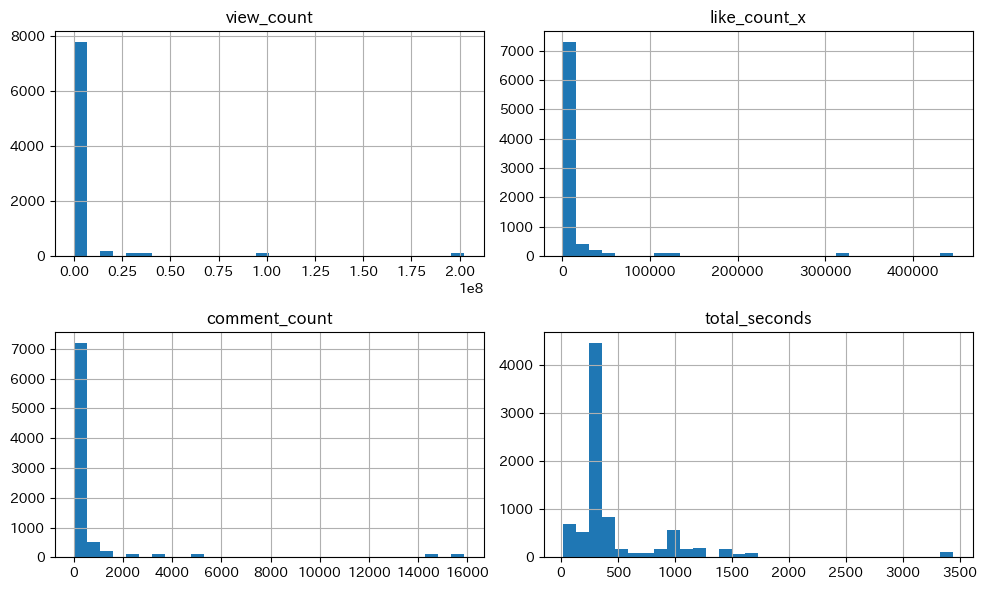

In [50]:
import matplotlib.pyplot as plt

numeric_cols = ["view_count", "like_count_x", "comment_count", "total_seconds"]
video_comment_df[numeric_cols].hist(bins=30, figsize=(10,6))
plt.tight_layout()
plt.show()

- 2億回再生の動画や14000件以上のコメント、40万件以上の高評価がついているヒット動画を確認

In [51]:
video_comment_df[video_comment_df["like_count_x"] >= 400000]

,video_id,title,published_at_x,view_count,like_count_x,comment_count,duration,tags,total_seconds,comment_id,author_display_name,published_at_y,text_display,like_count_y
2999,J5Z7tIq7bco,スキマスイッチ - 「奏（かなで）」Music Video : SUKIMASWITCH /...,2008-12-08 08:04:59,202509802,446009,15880,PT5M45S,"ボクと君,OFFICEAUGUSTA,SHORTFILM,SUKIMASWITCH,Kanade",345,UgwKHIzOWuhKzClKIzJ4AaABAg,@suu_12o,2023-10-17 07:57:03,文化祭で歌います！とても素晴らしい曲です😭 絶対1位取ります！,63.0
3000,J5Z7tIq7bco,スキマスイッチ - 「奏（かなで）」Music Video : SUKIMASWITCH /...,2008-12-08 08:04:59,202509802,446009,15880,PT5M45S,"ボクと君,OFFICEAUGUSTA,SHORTFILM,SUKIMASWITCH,Kanade",345,UgwPny8q8ARJQpDSca54AaABAg,@ぬん-p2x,2021-08-17 15:33:30,高1の時クラスが最悪で辛かったけどこの歌を毎日聞いて乗り越えました。今はもう大学1年生です。...,133.0
3001,J5Z7tIq7bco,スキマスイッチ - 「奏（かなで）」Music Video : SUKIMASWITCH /...,2008-12-08 08:04:59,202509802,446009,15880,PT5M45S,"ボクと君,OFFICEAUGUSTA,SHORTFILM,SUKIMASWITCH,Kanade",345,UgwTHrzoFra6neZB91B4AaABAg,@シバハル-d5f,2023-10-19 12:21:41,結構モニタリングは感動を与えてくれます!<br>まさか、奏まで聴けるなんて😂,226.0
3002,J5Z7tIq7bco,スキマスイッチ - 「奏（かなで）」Music Video : SUKIMASWITCH /...,2008-12-08 08:04:59,202509802,446009,15880,PT5M45S,"ボクと君,OFFICEAUGUSTA,SHORTFILM,SUKIMASWITCH,Kanade",345,UgwYVjQil2yjvjR9ovF4AaABAg,@ChiYuchi-e3i,2025-08-16 13:05:28,トークハンサムから来ました！<br>寺西くんが歌ってて本家も聴きたくなりました。<br>やっ...,34.0
3003,J5Z7tIq7bco,スキマスイッチ - 「奏（かなで）」Music Video : SUKIMASWITCH /...,2008-12-08 08:04:59,202509802,446009,15880,PT5M45S,"ボクと君,OFFICEAUGUSTA,SHORTFILM,SUKIMASWITCH,Kanade",345,UgwfnmbO950ERmBdfAl4AaABAg,@marvelousshimons1963,2023-05-18 00:30:26,【歌詞】\r<br>改札の前つなぐ手と手\r<br>いつものざわめき 新しい風\r<br>明...,4546.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3094,J5Z7tIq7bco,スキマスイッチ - 「奏（かなで）」Music Video : SUKIMASWITCH /...,2008-12-08 08:04:59,202509802,446009,15880,PT5M45S,"ボクと君,OFFICEAUGUSTA,SHORTFILM,SUKIMASWITCH,Kanade",345,UgzcNfKUGx4TsG68tlx4AaABAg,@たぬん-t4l,2023-10-19 11:54:59,良い唄は何年経っても聴いてしまう,132.0
3095,J5Z7tIq7bco,スキマスイッチ - 「奏（かなで）」Music Video : SUKIMASWITCH /...,2008-12-08 08:04:59,202509802,446009,15880,PT5M45S,"ボクと君,OFFICEAUGUSTA,SHORTFILM,SUKIMASWITCH,Kanade",345,UgzdHIBNmnBEBoHCXUB4AaABAg,@kosiandesu,2025-08-13 16:58:05,2億きたぞーーー！おめでとうございます～！🎉🎉🎉<br>2025 8月14日 木曜日 <br...,274.0
3096,J5Z7tIq7bco,スキマスイッチ - 「奏（かなで）」Music Video : SUKIMASWITCH /...,2008-12-08 08:04:59,202509802,446009,15880,PT5M45S,"ボクと君,OFFICEAUGUSTA,SHORTFILM,SUKIMASWITCH,Kanade",345,UgziR10ubxTp2cYhRrN4AaABAg,@美智子-o4o,2022-08-18 01:38:16,いつ聴いても心に響く<br>歌です<br>良い歌詞ですよね<br>君か大人になって行く<br...,367.0
3097,J5Z7tIq7bco,スキマスイッチ - 「奏（かなで）」Music Video : SUKIMASWITCH /...,2008-12-08 08:04:59,202509802,446009,15880,PT5M45S,"ボクと君,OFFICEAUGUSTA,SHORTFILM,SUKIMASWITCH,Kanade",345,Ugzqlz_g2lW2m5dauPl4AaABAg,@kotematsuri,2020-04-27 07:59:52,「君がどこに行ったって 僕の声で守るよ」 最もグッとくるポイント,431.0


## タイトルでグルーピングしてヒット動画を確認する

In [52]:
video_summary = (
    video_comment_df.groupby("title", as_index= False)
    .agg({"view_count": "first",
          "comment_count": "first",
          "like_count_x": "first",
          "total_seconds": "first"})
    .sort_values("comment_count", ascending=False)
)
video_summary.head(n=10)

,title,view_count,comment_count,like_count_x,total_seconds
56,スキマスイッチ - 「奏（かなで）」Music Video : SUKIMASWITCH /...,202509802,15880,446009,345
53,スキマスイッチ - 「全力少年」Music Video : SUKIMASWITCH / Z...,99353383,14385,320148,282
49,スキマスイッチ - 「ボクノート」Music Video：SUKIMASWITCH - BO...,35934837,5250,118905,356
45,スキマスイッチ - 「ゴールデンタイムラバー」Music Video : SUKIMASWI...,29515458,3596,123529,343
37,スキマスイッチ - 「Revival」Music Video - SUKIMASWITCH,4826857,2225,56158,319
44,スキマスイッチ - 「ガラナ」Music Video：SUKIMASWITCH - GUAR...,17421959,1544,33193,269
90,スキマスイッチ：SUKIMASWITCH / 奏（かなで）：KANADE 1億回突破記念！...,18928868,1175,44310,325
42,スキマスイッチ - 「アイスクリーム シンドローム」Music Video： SUKIMAS...,2039323,832,18313,308
6,"「ゴールデンタイムラバー」from TOUR 2010 ""LAGRANGIAN POINT""...",2793447,591,16845,471
43,スキマスイッチ - 「アカツキの詩」Music Video：SUKIMASWITCH - A...,5196224,590,13313,283


- ヒット動画の傾向を把握するためにペアプロットで可視化

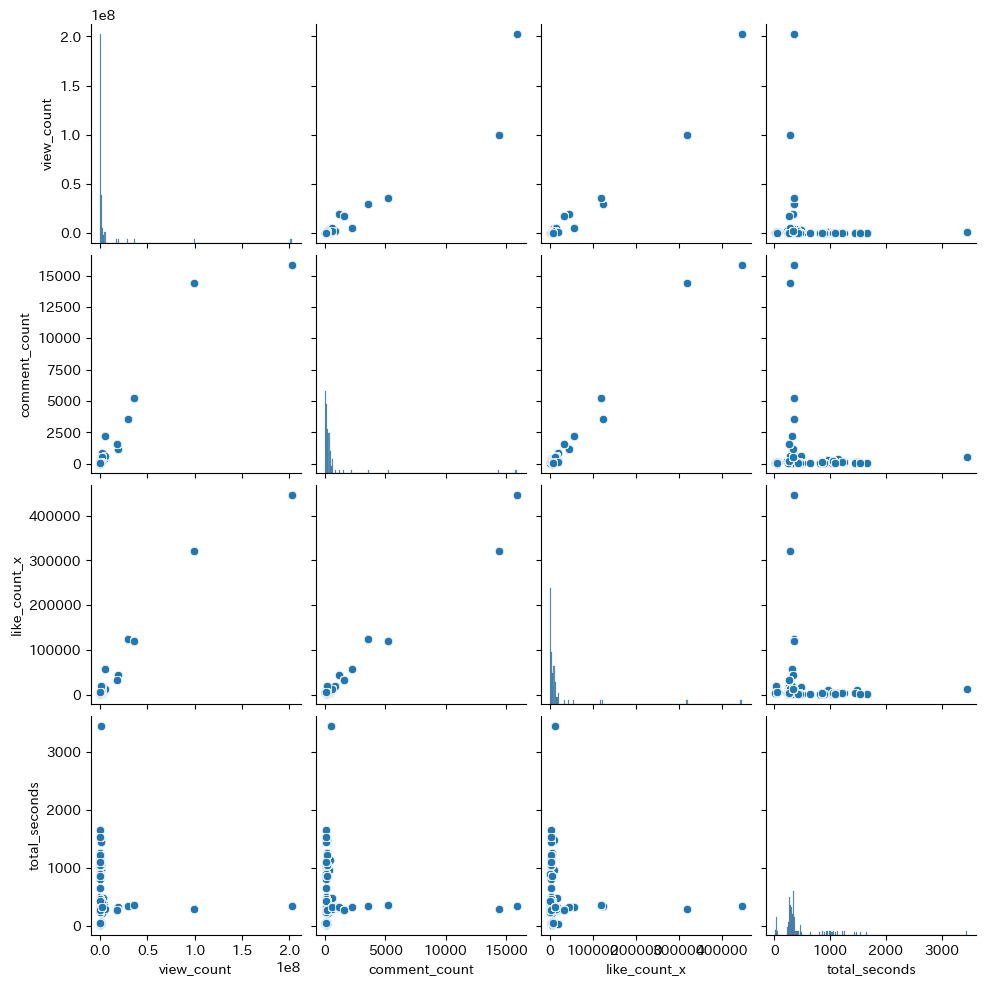

In [53]:
import seaborn as sns 
sns.pairplot(video_comment_df[["view_count", "comment_count", "like_count_x","total_seconds"]])
plt.show()

- 正の相関関係がありそうだが動画の分布が偏っているため対数をとって可視化する

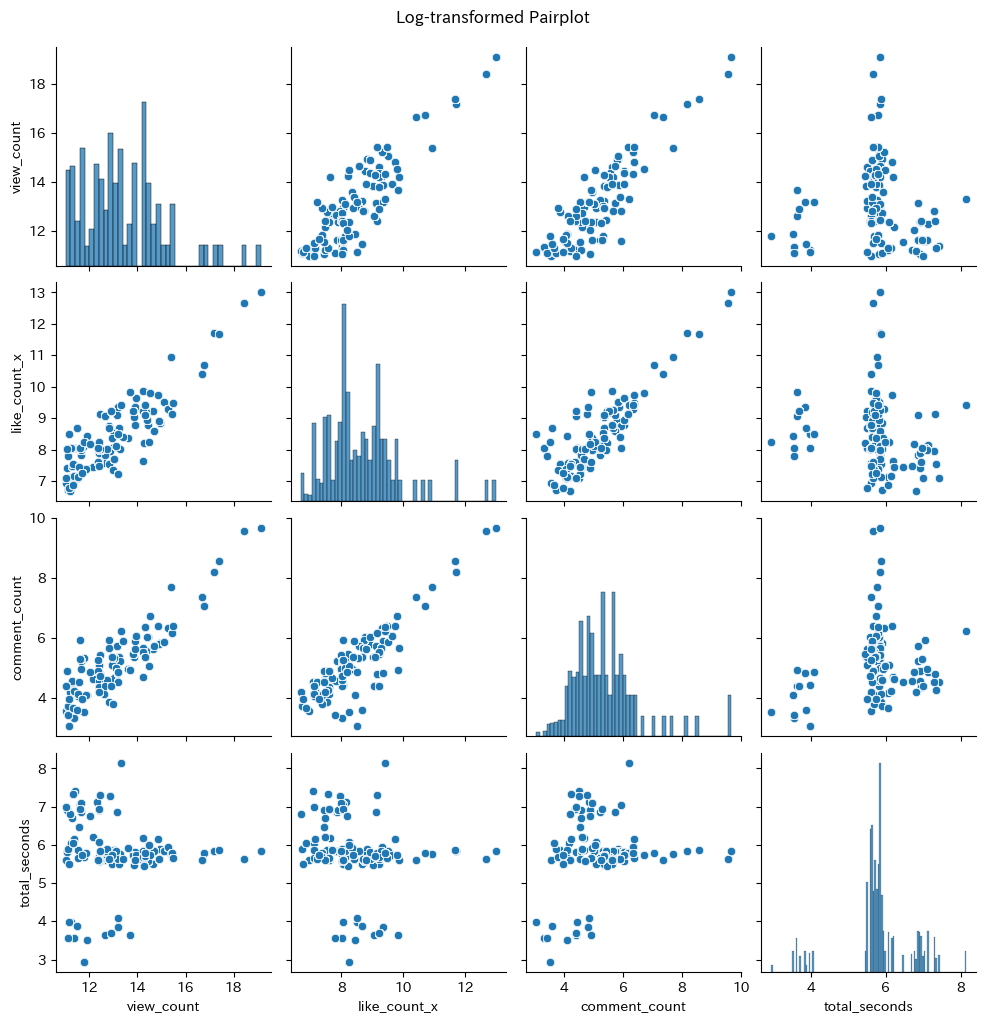

In [54]:
import numpy as np
cols = ["view_count", "like_count_x", "comment_count", "total_seconds"]

# 対数変換（0はNaN扱いすることで無視して計算できる）
video_comment_df[cols] = video_comment_df[cols].replace(0, np.nan)
video_comment_df_log = np.log1p(video_comment_df[cols])  
# log(1+x）で小さな値でもなめらかに扱える　
# np.log(1 + x)だとxが小さいと誤差が生まれる？


sns.pairplot(video_comment_df_log)
plt.suptitle("Log-transformed Pairplot", y=1.02)
plt.show()

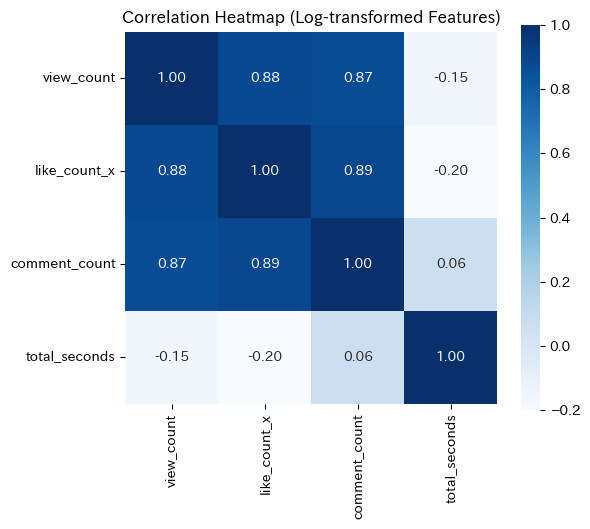

In [55]:
# 相関行列を計算
corr = video_comment_df_log.corr()
# ヒートマップ描画
plt.figure(figsize=(6, 5))
sns.heatmap(
    corr, 
    annot=True,       # 相関係数の値を表示
    fmt=".2f",        # 小数点2桁
    cmap="Blues",     # カラーマップ（他に "coolwarm", "viridis" などもおすすめ）
    square=True,      # 正方形に整える
    cbar=True         # 右にカラーバーを表示
)
plt.title("Correlation Heatmap (Log-transformed Features)")
plt.show()

### 対数変換後の指標間の関係

- 対数変換を行うことで、極端な外れ値の影響が抑えられ、各指標間の関係性がより明確に可視化できた。  

- 再生数（view_count）、高評価数（like_count_x）、コメント数（comment_count）の間では、依然として強い正の相関（0.87〜0.89程度）が確認された。  
- これら3指標は動画の「人気度」を構成する共通の要素であり、人気の高い動画ほどユーザーの反応も多い傾向が明確に表れている。

- 一方、再生時間（total_seconds）は他の指標との相関が低く（-0.20〜0.06程度）、動画の長さは再生数や評価数とはほとんど関係がないことが分かる。  
- したがって、動画の長さよりも“内容や話題性”が人気やエンゲージメントに影響している可能性が高いと考えられる。

## YouTubeコメントのテキスト前処理と自然言語分析の準備

- まずは、コメント文を自然言語処理に適した形に整える。  
- 絵文字・URL・記号・改行などのノイズを除去し、日本語の単語解析や感情分析に向けたクリーンなテキストを作成する。

In [56]:
TS_INLINE = r'(?:^|\s)(?:\d{1,2}[:：]){1,2}\d{2}(?:\s?[-–—~〜]\s?(?:\d{1,2}[:：]){1,2}\d{2})?(?=\s|$)'
BRACKETS  = r'\[(?:\d{1,2}[:：]){1,2}\d{2}\]'        # [1:23] みたいな括弧付き

In [57]:
import re
def clean_text(s):
    if not isinstance(s, str):
        return ""
    s = re.sub(r"<.*?>", "", s)                      # HTMLタグ全体を除去
                                                     # タイムスタンプ削除
    s = re.sub(BRACKETS,  " ", s)                    # [1:23] のような表記を削除
    s = re.sub(TS_INLINE, " ", s)                    # 文中の 0:45 や 1:02:03、範囲 0:10〜0:30 も削除
    
    s = re.sub(r"http\s+", "", s)                    #URL除去
    s = re.sub(r"@[A-Za-z0-9_]+", "", s)             # メンション除去
    s = re.sub(r"[!-/:-@[-`{-~]", "", s)             # 英数記号除去
    s = re.sub(r"[^\w\sぁ-んァ-ヶ一-龠々]", "", s)     # 絵文字や特殊記号除去
    s = re.sub(r"\s+", " ", s)                       # 余分な空白を１つに
    s = s.strip()
    return s

In [58]:
video_comment_df["clean_text"] = video_comment_df["text_display"].apply(clean_text)
video_comment_df.columns

Index(['video_id', 'title', 'published_at_x', 'view_count', 'like_count_x',
       'comment_count', 'duration', 'tags', 'total_seconds', 'comment_id',
       'author_display_name', 'published_at_y', 'text_display', 'like_count_y',
       'clean_text'],
      dtype='object')

In [59]:
# 元のコメントとクリーン後のコメントを並べて確認
video_comment_df[["text_display", "clean_text"]].head(5)

,text_display,clean_text
0,やったー🎉さや香さん👏👏,やったーさや香さん
1,さや香のネタ初めて見たのですが面白いですね。ネタ見て笑ってる姿が可愛かったです。スキマの二人...,さや香のネタ初めて見たのですが面白いですねネタ見て笑ってる姿が可愛かったですスキマの二人がさ...
2,サムネのスキマスイッチが完全にトータルテンボスなんよ,サムネのスキマスイッチが完全にトータルテンボスなんよ
3,元々このネタ好きだったけどまさか本人の前でやる映像が見れるとはWWW,元々このネタ好きだったけどまさか本人の前でやる映像が見れるとはWWW
4,"<a href=""https://www.youtube.com/watch?v=0_Gml...",コンビ名つけるならトータルテンボスかな


## 📘テキストクリーニング結果の概要

- HTMLタグ（`<br>`など）や絵文字・特殊記号を削除  
- 「ありがとう」「大好き」など感情語が明瞭に残る  
- 後続の形態素解析や感情分析に適したクリーンな形式へ変換

## 形態素解析を行う

In [60]:
from janome.tokenizer import Tokenizer
from collections import Counter

t = Tokenizer()

# 名詞だけ抽出
video_comment_df["nouns"] = video_comment_df["clean_text"].apply(
    lambda x: [token.base_form for token in t.tokenize(x) if token.part_of_speech.startswith("名詞")]
)
# token.base_form は「原形」に変換（例：「食べた」→「食べる」） ⇒ 表記ゆれを減らせる


from collections import Counter

all_nouns = video_comment_df["nouns"].sum()  # 全文まとめて1つのリストに
freq = Counter(all_nouns)
freq.most_common(30)  # 上位30件

[('曲', 2498),
 ('スキマスイッチ', 1108),
 ('好き', 1045),
 ('さん', 1024),
 ('の', 979),
 ('ん', 969),
 ('人', 823),
 ('歌', 734),
 ('大好き', 643),
 ('時', 585),
 ('最高', 506),
 ('何', 499),
 ('今', 496),
 ('歌詞', 491),
 ('こと', 460),
 ('君', 458),
 ('よう', 451),
 ('ライブ', 445),
 ('スキマ', 433),
 ('年', 405),
 ('これ', 377),
 ('僕', 377),
 ('自分', 362),
 ('素敵', 357),
 ('中', 343),
 ('私', 339),
 ('声', 335),
 ('さ', 308),
 ('心', 307),
 ('前', 306)]

In [61]:
video_comment_df[["clean_text", "nouns"]].head(10)

,clean_text,nouns
0,やったーさや香さん,"[ー, さや香, さん]"
1,さや香のネタ初めて見たのですが面白いですねネタ見て笑ってる姿が可愛かったですスキマの二人がさ...,"[さや香, ネタ, の, ネタ, 姿, スキマ, 二, 人, さや香, ネタ, の]"
2,サムネのスキマスイッチが完全にトータルテンボスなんよ,"[サムネ, スキマスイッチ, 完全, トータルテンボス, ん]"
3,元々このネタ好きだったけどまさか本人の前でやる映像が見れるとはWWW,"[ネタ, 好き, 本人, 前, 映像, WWW]"
4,コンビ名つけるならトータルテンボスかな,"[コンビ, 名, トータルテンボス]"
5,流石ネタおっもろー,"[ネタ, もろ, ー]"
6,ミュージシャンはカバーあるけど漫才師もカバーしていいんじゃないかみたいなネタが作れそう,"[ミュージシャン, カバー, 漫才, 師, カバー, ん, みたい, ネタ, そう]"
7,さまぁずチャンネルのスタッフ感とテロップ感,"[さま, ぁず, チャンネル, スタッフ, 感, テロップ, 感]"
8,考えた事なかったけどやっぱり音楽はカバーアルバムとかもあるし漫才のネタよりアレンジの仕方とか...,"[事, 音楽, カバー, アルバム, 漫才, ネタ, アレンジ, 仕方, オリジナリティ, ..."
9,スキマスイッチの笑い声心地いい笑,"[スキマスイッチ, 笑い声, 心地, 笑]"


## 名詞の出現頻度を可視化（上位30語）

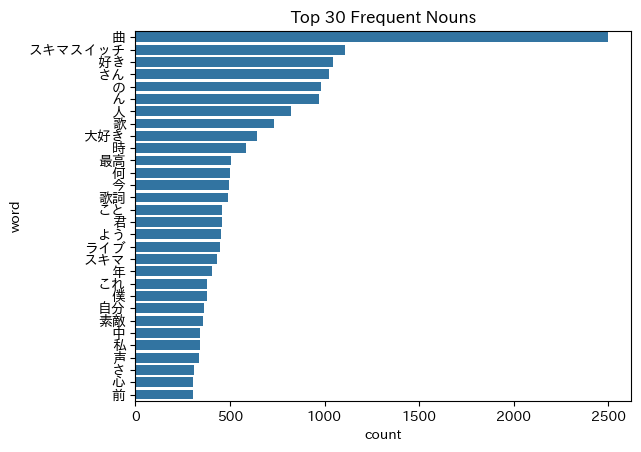

In [62]:
import japanize_matplotlib
freq_df = pd.DataFrame(freq.most_common(30), columns=["word", "count"])
sns.barplot(data=freq_df, y="word", x="count")
plt.title("Top 30 Frequent Nouns")
plt.show()

## ストップワード除去後の名詞頻度を再集計・可視化

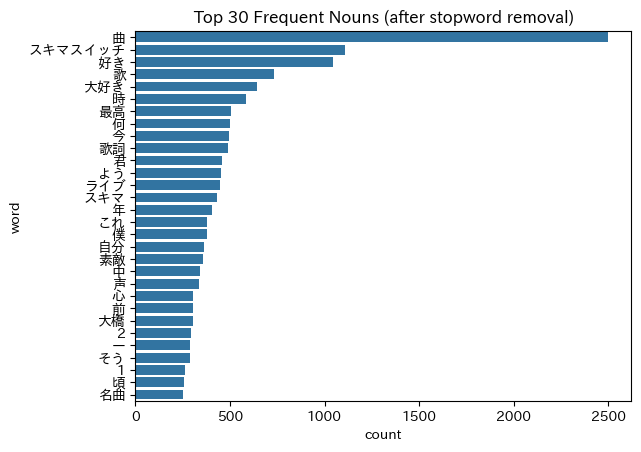

In [63]:
stopwords = ["さん", "の", "こと", "ん", "人", "笑", "私", "です","さ"]
all_nouns = [w for w in all_nouns if w not in stopwords]
# 再カウント
freq = Counter(all_nouns)
freq_df = pd.DataFrame(freq.most_common(30), columns=["word", "count"])
# 可視化
sns.barplot(data=freq_df, y="word", x="count")
plt.title("Top 30 Frequent Nouns (after stopword removal)")
plt.show()

## コメントテキストの頻出語をWordCloudで可視化

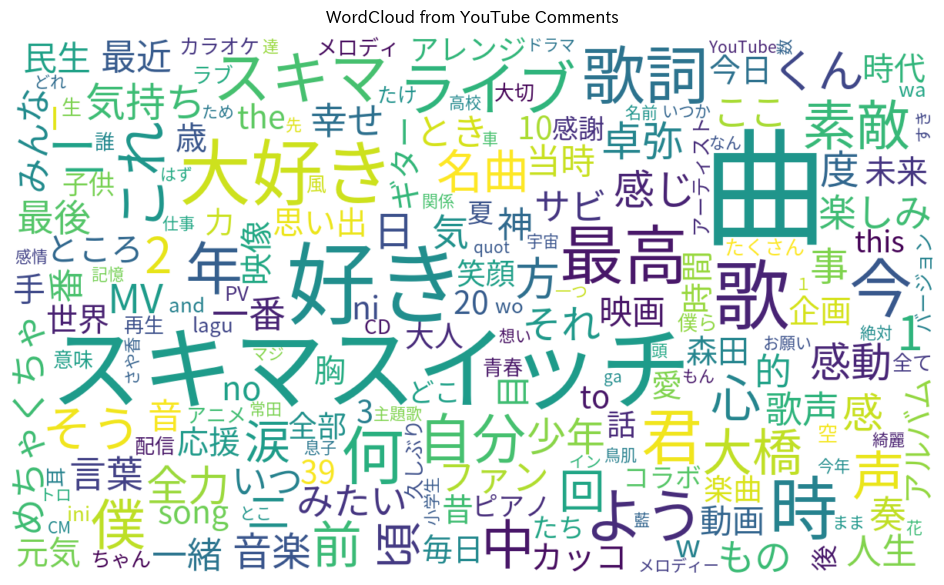

In [64]:
from wordcloud import WordCloud
from pathlib import Path

# フォントパスを明示
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"

# 頻度辞書
freq_dict = dict(freq)

# WordCloud作成
wc = WordCloud(
    width=1200, height=700,
    background_color="white",
    font_path=font_path,
    collocations=False,
    prefer_horizontal=0.95
).generate_from_frequencies(freq_dict)

# 表示
plt.figure(figsize=(12,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud from YouTube Comments", pad=10)
plt.show()

- Janomeで名詞を抽出し、頻出語をもとにWordCloudを作成した。
- ストップワードを除去した結果、「曲」「好き」「スキマスイッチ」「歌詞」「最高」「大好き」などが上位に現れ、コメントの多くが楽曲やアーティストへの好意的な内容で構成されていることが分かった。